In [ ]:
import os 
#os.getcwd()
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import scanpy as sc
import squidpy as sq
import pandas as pd
sc.logging.print_header()
#scanpy==1.10.3 anndata==0.10.8 umap==0.5.9.post2 numpy==1.24.4 scipy==1.13.1 pandas==2.3.3 scikit-learn==1.6.1 statsmodels==0.14.5 igraph==0.11.9 pynndescent==0.5.13

In [ ]:
adata = sc.read_h5ad("./SLN_SMI6k_data.h5ad")

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

plt = sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:

plotpath = "./Plot/"
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

ax = sc.pl.highly_variable_genes(adata, show=False)

In [ ]:
#adata.X
# acquire dataset with only HVGs
adata=adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['nCount']) 

In [ ]:
# scale each gene
sc.pp.scale(adata, max_value=10)

In [ ]:
hvg_genes = adata.var[adata.var['highly_variable']].index.tolist()

In [ ]:
sc.external.pp.bbknn(adata, batch_key='sample')

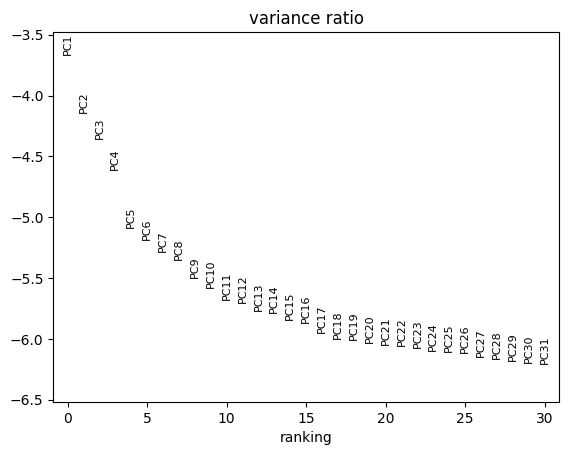

In [42]:
# pca analysis
#check single PC's contribution to toal data SEM
sc.pl.pca_variance_ratio(adata, log=True)

In [43]:
sc.tl.umap(adata)

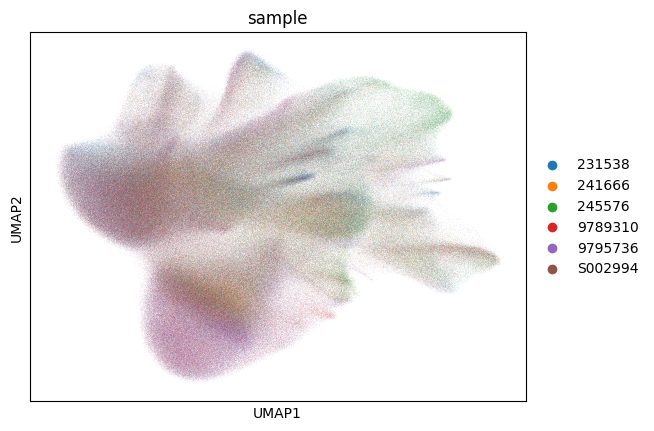

In [44]:
sc.pl.umap(adata, color='sample',use_raw=False)

In [74]:
# step2 acquire clusters and score
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

df=pd.DataFrame(
    {group + '_' + key[:1]:result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(25)
df.to_csv("./Docu/cluster_marker_12.csv", index=True)

In [33]:
cluster2annotation = {
    "0": "T",
    "1": "B",
    "2": "Mye",
    "3": "Fib",
    "4": "Endo",
    "5": "Mye",
    "6": "NK",
    "7": "cDC3",
    "8": "Plasma",
    "9": "pDC",
    "10":"Mye",# CD14_mono
    "11":"Mast"
}

adata.obs["cell_type_layer1"] = adata.obs["leiden_0.5"].map(cluster2annotation).astype("category")

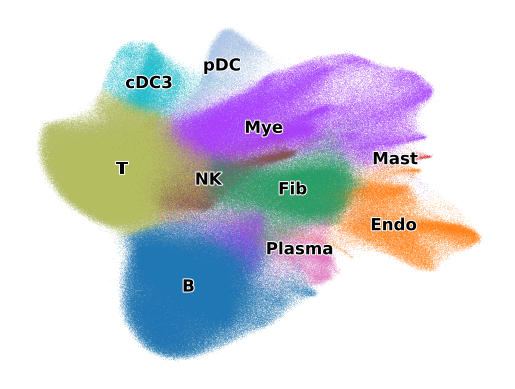

In [93]:

sc.pl.umap(
    adata,
    s=0.3,
    color="cell_type_layer1",
    size=15,
    frameon=False,
    legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=1.5,
    title="",
    show=False  
)


In [ ]:
gene_sets = {
    'T': ['CD3D', 'CD3E', 'CD4', 'CD8A', 'CD8B'],
    'B': ['CD79B', 'CD79A', 'MS4A1', 'CD19', 'CXCL13'],
    'Fib': ['COL1A1', 'COL6A1', 'VIM', 'VCAM1', 'DCN'],
    'Mye': ['APOE', 'C1QC', 'C1QA', 'APOC1', 'CD68'],
    'cDC3': ['LAMP3', 'CCR7', 'CCL19', 'CD40', 'KDM2B'],
    'Endo': ['VWF', 'CD34', 'PLVAP', 'PECAM1', 'LYVE1'],
    'NK': ['NKG7', 'GZMK', 'GNLY', 'KLRK1', 'NCAM1'],
    'Plasma': ['IGHG1/2', 'IGLL5', 'JCHAIN', 'MZB1', 'SDC1'],
    'pDC': ['CLEC4C', 'LILRA4', 'IL3RA', 'JCHAIN', 'SPIB'],
    'Mast': ['TPSAB1/2', 'CPA3', 'KIT']
}

for cell_type, markers in gene_sets.items():
    valid_markers = [gene for gene in markers if gene in adata.var_names]
    sc.tl.score_genes(adata, valid_markers, score_name=f'{cell_type}_score')

score_columns = [f'{cell_type}_score' for cell_type in gene_sets.keys() if f'{cell_type}_score' in adata.obs.columns]

sc.pl.umap(
    adata, 
    color=score_columns,
    ncols=4,  
    cmap='RdBu_r', 
    vcenter=0,  #
    show=False,
    s=5,  
    frameon=False
)

plt.suptitle('Cell Type Marker Scores', y=1.02, fontsize=16)
plt.tight_layout()

output_dir = "./Plot/"
os.makedirs(output_dir, exist_ok=True)

plt.savefig(
    f"{output_dir}adata.umap_Marker_scores.png", 
    dpi=300, 
    bbox_inches='tight'
)
plt.savefig(
    f"{output_dir}adata.umap_Marker_scores.pdf", 
    bbox_inches='tight'
)


plt.show()

/tmp/ipykernel_2817697/1162492347.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


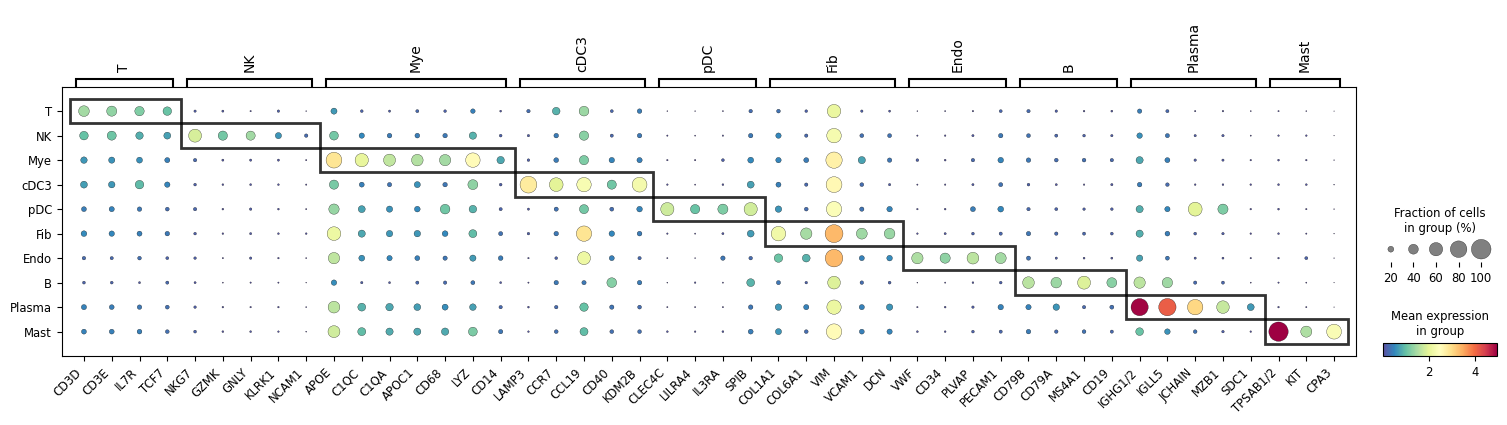

In [12]:
import scanpy as sc
import matplotlib.pyplot as plt
import os

# 确保保存路径的目录存在
#os.makedirs("./Plot", exist_ok=True)

marker_genes_dict = {
                      "T": ['CD3D','CD3E','IL7R','TCF7',],
                      "NK": ['NKG7','GZMK','GNLY','KLRK1','NCAM1'],  
                      "Mye": ['APOE','C1QC','C1QA','APOC1','CD68','LYZ','CD14',],
                      "cDC3": ['LAMP3','CCR7','CCL19','CD40','KDM2B'], 
                      "pDC": ['CLEC4C','LILRA4','IL3RA','SPIB'],
                      "Fib": ['COL1A1','COL6A1','VIM','VCAM1','DCN'],
                      "Endo": ['VWF','CD34','PLVAP','PECAM1',],
                      "B": ['CD79B','CD79A','MS4A1','CD19'],
                      "Plasma": ['IGHG1/2','IGLL5','JCHAIN','MZB1','SDC1'],                              
                      "Mast": ['TPSAB1/2','KIT','CPA3'],
}


ordered_cell_types = [
    "T", "NK", "Mye","cDC3","pDC", "Fib","Endo", "B", "Plasma", "Mast" ]


adata.obs['cell_type_layer1'] = (
    adata.obs['cell_type_layer1']
    .astype('category')
    .cat.reorder_categories(ordered_cell_types)
)


result = sc.pl.dotplot(
    adata,
    marker_genes_dict,
    groupby='cell_type_layer1',
    use_raw=True,
    dendrogram=False,
    cmap='Spectral_r',
    swap_axes=False,
    show=False  
)



In [36]:
adata.write("/data/0_zq/TDLNprogram/data/SMI6k/SMI6k_data_analysis/Squidpy/Docu/Layer2/TNBC_NACT_SLN_SMI6k_qc_hvg_BBKNN_scanpy.h5ad")

In [102]:
adata_T = raw_adata[raw_adata.obs['cell_type_layer1']=='T'].copy()
adata_NK = raw_adata[raw_adata.obs['cell_type_layer1']=='NK'].copy()
adata_B = raw_adata[raw_adata.obs['cell_type_layer1']=='B'].copy()
adata_Mye = raw_adata[raw_adata.obs['cell_type_layer1']=='Mye'].copy()
adata_Plasma = raw_adata[raw_adata.obs['cell_type_layer1']=='Plasma'].copy()
adata_cDC3 = raw_adata[raw_adata.obs['cell_type_layer1']=='pDC'].copy()
adata_pDC = raw_adata[raw_adata.obs['cell_type_layer1']=='cDC3'].copy()
adata_Endo = raw_adata[raw_adata.obs['cell_type_layer1']=='Endo'].copy()
adata_Fib = raw_adata[raw_adata.obs['cell_type_layer1']=='Fib'].copy()
adata_Mast = raw_adata[raw_adata.obs['cell_type_layer1']=='Mast'].copy()

In [111]:
adata_Mye_merged = sc.AnnData.concatenate(adata_Mye, adata_pDC,adata_cDC3)

/tmp/ipykernel_1731574/3008701585.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_Mye_merged = sc.AnnData.concatenate(adata_Mye, adata_pDC,adata_cDC3)


In [112]:
adata_B_merged = sc.AnnData.concatenate(adata_B, adata_Plasma)

/tmp/ipykernel_1731574/82850843.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_B_merged = sc.AnnData.concatenate(adata_B, adata_Plasma)


In [113]:
adata_T_merged = sc.AnnData.concatenate(adata_T, adata_NK)

/tmp/ipykernel_1731574/4267414526.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_T_merged = sc.AnnData.concatenate(adata_T, adata_NK)


In [ ]:
##########################################
     End of first layer annotation
##########################################